### Importing Skin Cancer Data


### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [13]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
#   Defining the path for train and test images
##  Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Test')

In [ ]:
!ls

gdrive	sample_data


In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
## resizing  images to the size img_height*img_width, while writting the dataset
batch_size = 32
img_height = 180
img_width = 180

we are splitting the data set 80% of the images for training, and 20% for validation.

In [17]:
## using  seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [18]:
## using  seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [19]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [20]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [21]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


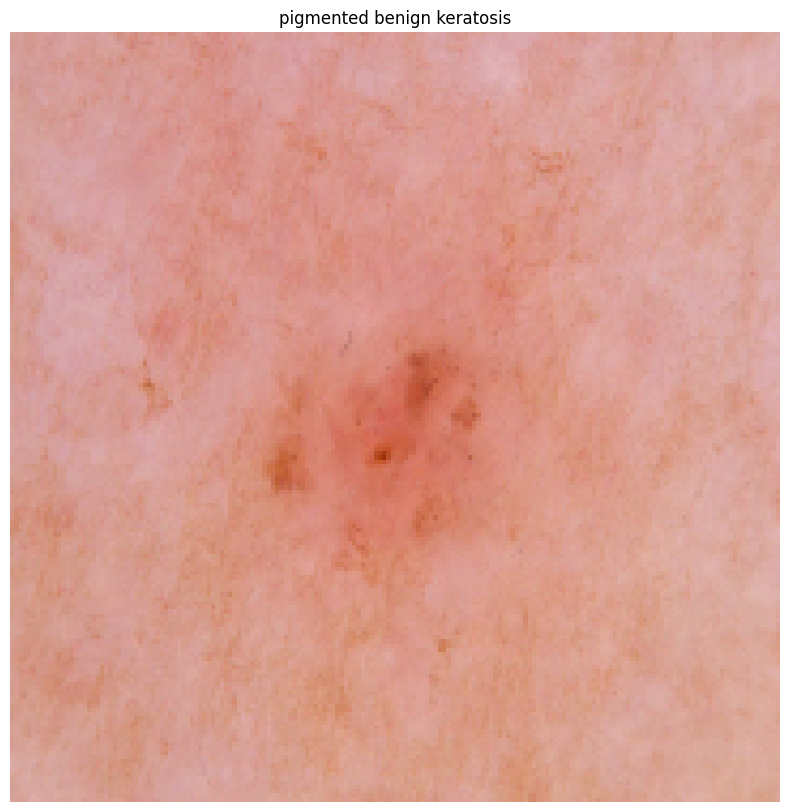

In [22]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[1].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

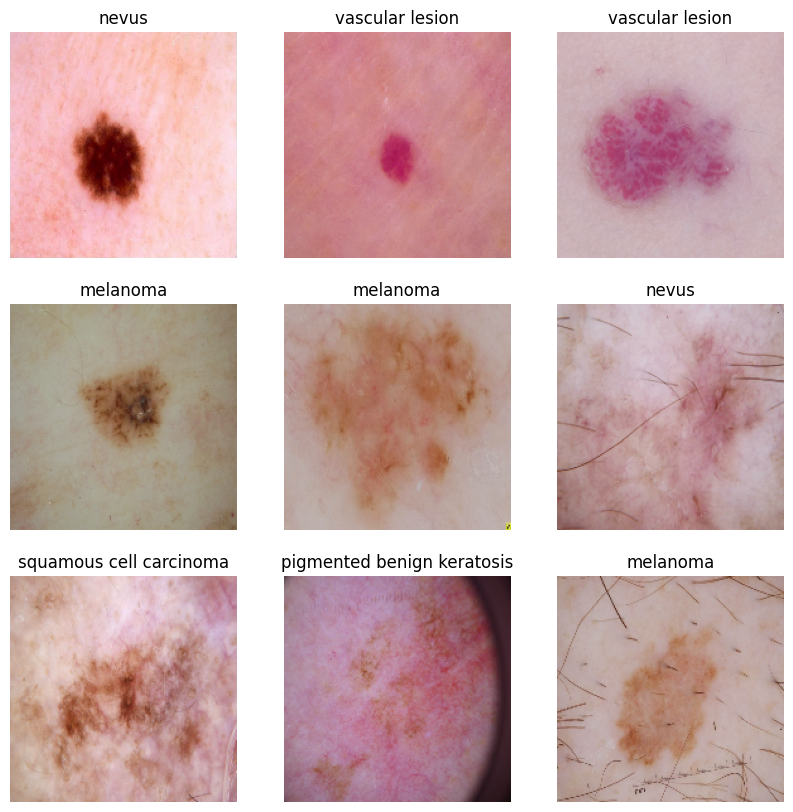

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [24]:
print(type(train_ds))
print(len(train_ds))


<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
56


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:

num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
  # View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
### choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:


import time

# Record start time
start_time = time.time()
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time

Epoch 1/20
56/56 [==============================] - 289s 3s/step - loss: 2.0895 - accuracy: 0.2533 - val_loss: 1.8881 - val_accuracy: 0.2573
Epoch 2/20
56/56 [==============================] - 75s 1s/step - loss: 1.7513 - accuracy: 0.3560 - val_loss: 1.7666 - val_accuracy: 0.3691
Epoch 3/20
56/56 [==============================] - 75s 1s/step - loss: 1.5782 - accuracy: 0.4286 - val_loss: 1.5811 - val_accuracy: 0.4698
Epoch 4/20
56/56 [==============================] - 74s 1s/step - loss: 1.4635 - accuracy: 0.4961 - val_loss: 1.5988 - val_accuracy: 0.4452
Epoch 5/20
56/56 [==============================] - 73s 1s/step - loss: 1.4078 - accuracy: 0.5095 - val_loss: 1.4093 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 74s 1s/step - loss: 1.2835 - accuracy: 0.5435 - val_loss: 1.6775 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 75s 1s/step - loss: 1.2309 - accuracy: 0.5603 - val_loss: 1.4064 - val_accuracy: 0.5235
Epoch 8/20
56/56 [=

In [ ]:
print(elapsed_time)

1873.9067709445953


### Train the model

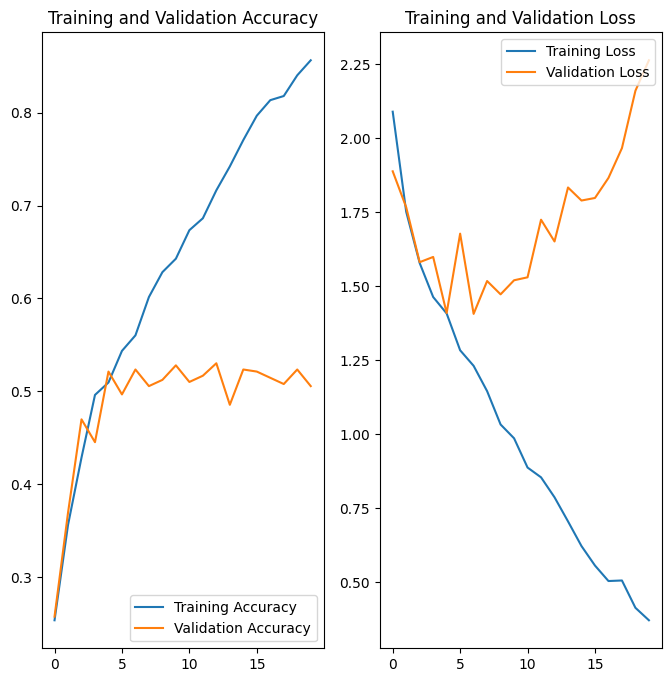

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Checking the accuracy and loss by adding more layers

In [26]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [27]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       1

In [28]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
import time

# Record start time
start_time = time.time()

# Your code goes here


epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# Record end time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time

Epoch 1/5
56/56 [==============================] - 402s 7s/step - loss: 2.1348 - accuracy: 0.2204 - val_loss: 1.9283 - val_accuracy: 0.2841
Epoch 2/5
56/56 [==============================] - 336s 6s/step - loss: 1.8742 - accuracy: 0.3125 - val_loss: 1.8062 - val_accuracy: 0.3468
Epoch 3/5
56/56 [==============================] - 347s 6s/step - loss: 1.6642 - accuracy: 0.3817 - val_loss: 1.4766 - val_accuracy: 0.4855
Epoch 4/5
56/56 [==============================] - 327s 6s/step - loss: 1.4607 - accuracy: 0.4983 - val_loss: 1.5528 - val_accuracy: 0.4787
Epoch 5/5
56/56 [==============================] - 325s 6s/step - loss: 1.3985 - accuracy: 0.5156 - val_loss: 1.3943 - val_accuracy: 0.5235


### Visualizing training results

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

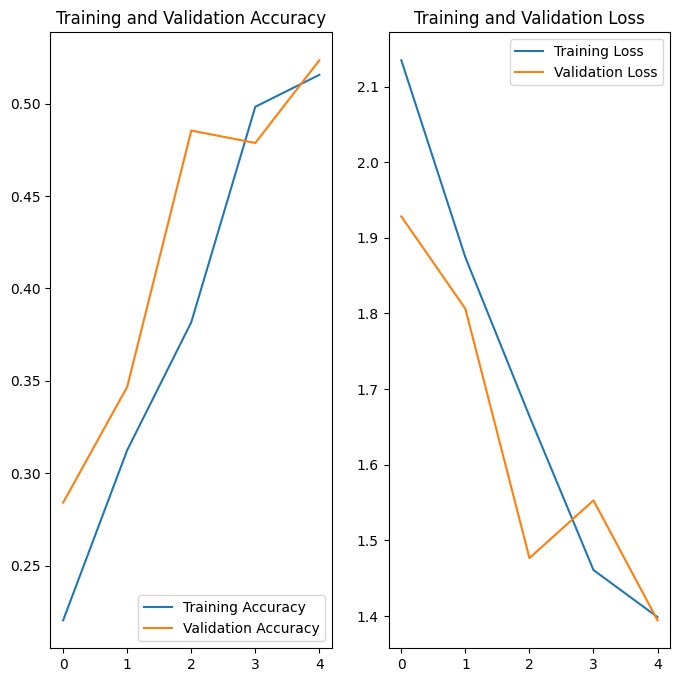

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Still the accuracy hasnt increase much after modfiying the filetr size.

### Write your findings here

We are augmenting the data as it can imporove the accuracy as it introduces Increased Dataset Size,Improved Robustness also its validation accuracy increases.

In [ ]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

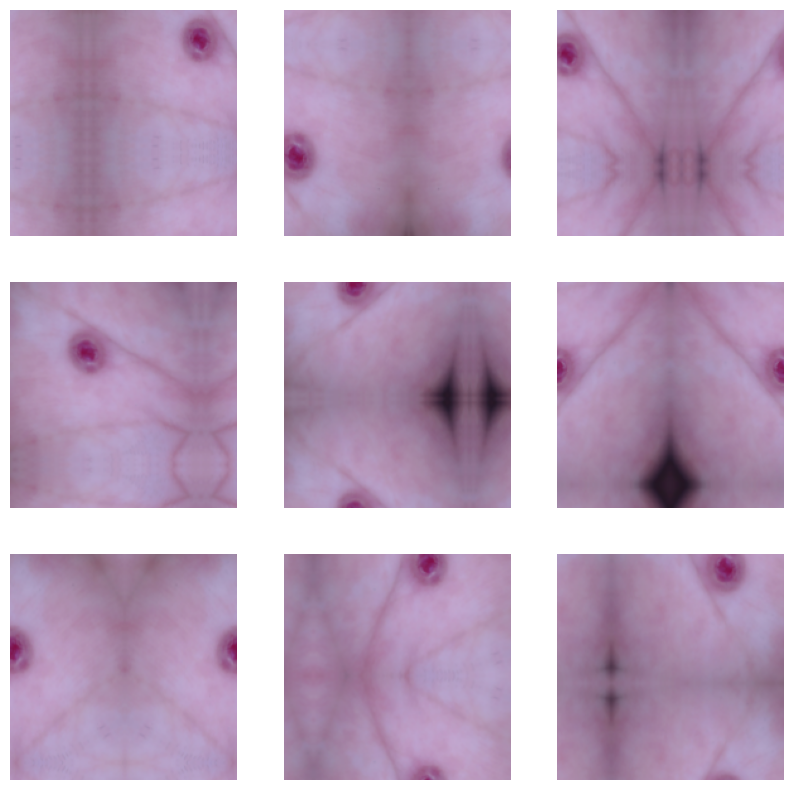

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes=9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 243s 4s/step - loss: 1.8706 - accuracy: 0.3041 - val_loss: 1.7216 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 131s 2s/step - loss: 1.7264 - accuracy: 0.3566 - val_loss: 1.6084 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 136s 2s/step - loss: 1.6075 - accuracy: 0.3901 - val_loss: 1.5523 - val_accuracy: 0.4609
Epoch 4/20
56/56 [==============================] - 131s 2s/step - loss: 1.5909 - accuracy: 0.4068 - val_loss: 1.5997 - val_accuracy: 0.4072
Epoch 5/20
56/56 [==============================] - 121s 2s/step - loss: 1.6606 - accuracy: 0.3789 - val_loss: 1.5535 - val_accuracy: 0.4586
Epoch 6/20
56/56 [==============================] - 135s 2s/step - loss: 1.5462 - accuracy: 0.4230 - val_loss: 1.5358 - val_accuracy: 0.4497
Epoch 7/20
56/56 [==============================] - 122s 2s/step - loss: 1.5070 - accuracy: 0.4336 - val_loss: 1.4634 - val_accuracy: 0.4609
Epoch 8/20
56

### Visualizing the results

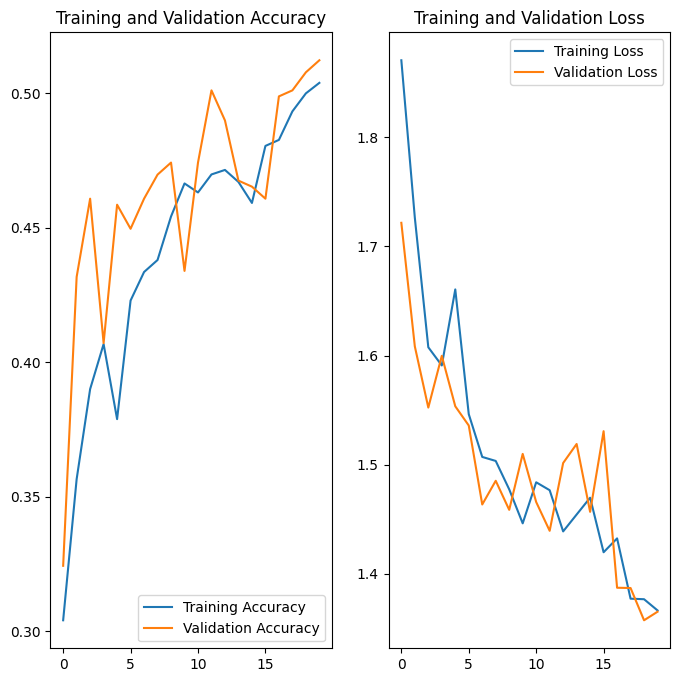

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the above graph the accuracy has increased for both train and validation set ,and also losses are similar.

Now lets try to see if there is any data imbalance and try to fix that issue and see if it increases accuracy of the model.

In [ ]:
# For convenience, let us set up the path for the training and validation sets
train_dir = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train')
val_dir = os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Test')



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


### Training by chaging the hyperparameters and adding droup out.

In [ ]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

#2D convolution layer (e.g. spatial convolution over images).
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))
#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Flattens the input. Does not affect the batch size.
model.add(Flatten())

#https://keras.io/api/layers/regularization_layers/dropout/
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

#Just your regular densely-connected NN layer.
#Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
#It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
#Dense implements the operation: output = activation(dot(input, kernel)
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=epochs
)


Epoch 1/10
23/23 [==============================] - 131s 6s/step - loss: 2.9065 - accuracy: 0.2126 - val_loss: 2.1961 - val_accuracy: 0.1441
Epoch 2/10
23/23 [==============================] - 104s 4s/step - loss: 1.8576 - accuracy: 0.3336 - val_loss: 2.1081 - val_accuracy: 0.2373
Epoch 3/10
23/23 [==============================] - 102s 4s/step - loss: 1.6865 - accuracy: 0.3854 - val_loss: 2.1810 - val_accuracy: 0.3051
Epoch 4/10
23/23 [==============================] - 102s 4s/step - loss: 1.6415 - accuracy: 0.4149 - val_loss: 2.3685 - val_accuracy: 0.3220
Epoch 5/10
23/23 [==============================] - 101s 4s/step - loss: 1.5669 - accuracy: 0.4252 - val_loss: 2.3461 - val_accuracy: 0.3220
Epoch 6/10
23/23 [==============================] - 109s 5s/step - loss: 1.4476 - accuracy: 0.4953 - val_loss: 2.2500 - val_accuracy: 0.3559
Epoch 7/10
23/23 [==============================] - 104s 4s/step - loss: 1.4110 - accuracy: 0.5105 - val_loss: 2.2494 - val_accuracy: 0.3644
Epoch 8/10
23

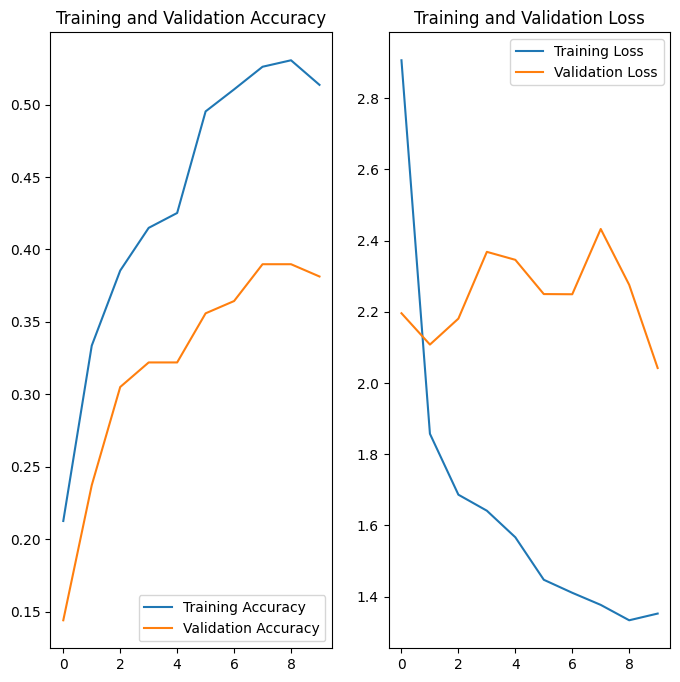

In [ ]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

 Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,melanoma
2235,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,melanoma
2236,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,melanoma
2237,/content/gdrive/MyDrive/Colab Notebooks/CCN_Pr...,melanoma


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)
Class=7, n=181 (8.084%)
Class=3, n=438 (19.562%)


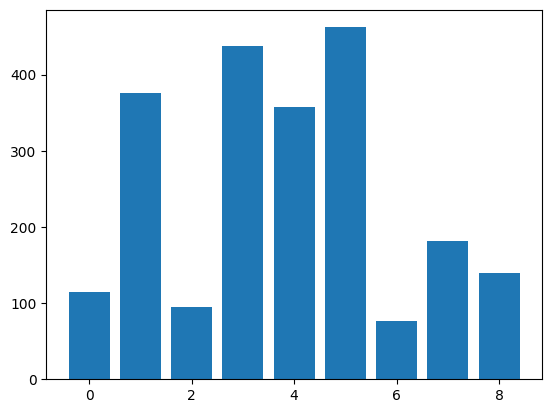

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

class 0,6 has least number of samples where as class 4,5
have more number od samples

Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

In [ ]:
#https://github.com/mdbloice/Augmentor
#https://github.com/mdbloice/Augmentor
datapath = r'/content/gdrive/MyDrive/Train/actinic keratosis'
import Augmentor
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A82359786A0>: 100%|██████████| 500/500 [00:25<00:00, 19.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8224B8EA70>: 100%|██████████| 500/500 [00:27<00:00, 18.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A823D756C80>: 100%|██████████| 500/500 [00:26<00:00, 19.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7A8235A0ADA0>: 100%|██████████| 500/500 [01:46<00:00,  4.71 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7A8235B83BB0>: 100%|██████████| 500/500 [01:45<00:00,  4.73 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A823423FD60>: 100%|██████████| 500/500 [00:24<00:00, 20.59 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A8224B8EA40>: 100%|██████████| 500/500 [00:47<00:00, 10.49 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A82246A6680>: 100%|██████████| 500/500 [00:25<00:00, 19.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train//vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A823423FD60>: 100%|██████████| 500/500 [00:24<00:00, 20.21 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_63074bb1-7c6e-4613-885f-b7b97ac184fc.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_086e5d89-ddfc-4533-b701-366279ba851f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028941.jpg_53b036bf-ed09-4c88-b6ca-68bf8ac974f4.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CCN_Project/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration (1)/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_aeb937ae-3bb5-4ae7-83b1-472787f

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-33-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

####  Create a training dataset

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:

num_classes = 9

####  Create your model

In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

####  Train your model

In [41]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 309s 2s/step - loss: 1.7828 - accuracy: 0.3255 - val_loss: 1.5169 - val_accuracy: 0.4172
Epoch 2/20
169/169 [==============================] - 231s 1s/step - loss: 1.3855 - accuracy: 0.4716 - val_loss: 1.2699 - val_accuracy: 0.5189
Epoch 3/20
169/169 [==============================] - 225s 1s/step - loss: 1.1393 - accuracy: 0.5801 - val_loss: 1.0605 - val_accuracy: 0.5984
Epoch 4/20
169/169 [==============================] - 232s 1s/step - loss: 0.9356 - accuracy: 0.6588 - val_loss: 1.0110 - val_accuracy: 0.6340
Epoch 5/20
169/169 [==============================] - 232s 1s/step - loss: 0.7385 - accuracy: 0.7307 - val_loss: 0.8550 - val_accuracy: 0.7090
Epoch 6/20
169/169 [==============================] - 231s 1s/step - loss: 0.6103 - accuracy: 0.7838 - val_loss: 0.8429 - val_accuracy: 0.7023
Epoch 7/20
169/169 [==============================] - 230s 1s/step - loss: 0.4842 - accuracy: 0.8253 - val_loss: 0.7338 - val_accuracy: 0.7624

####  Visualize the model results

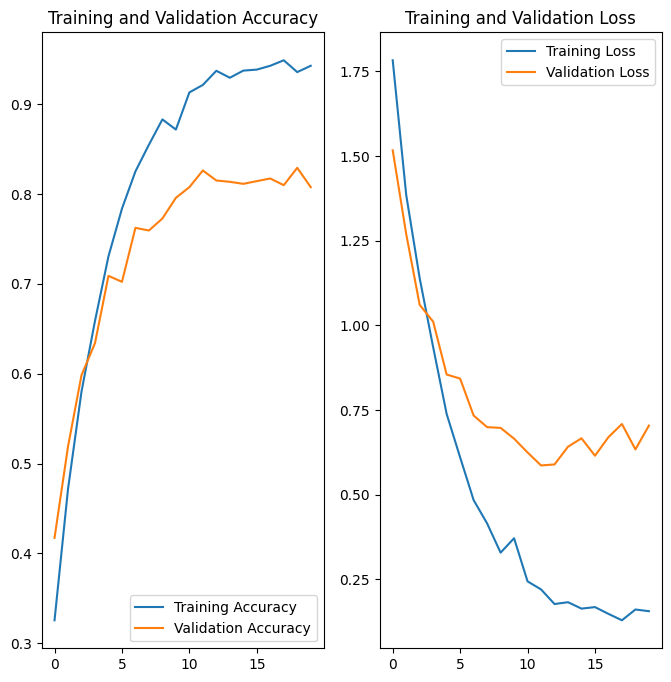

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



the model is predicting with 95% accuracy and decent amount of accuracy on validation data set ,it is also generalising good.

yes the class imbalance helped in increasing the accuracy , we have got rid of over fitting by using droup outs and normalizations. and adding augumnetations and by balancing the imbalance data set